In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import warnings
import scipy as sp
import time, copy, pickle, matplotlib, os, sys, math, random, itertools
import matplotlib.pyplot as plt
import networkx as nx

import torch_geometric as tg
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv, GCNConv, GATv2Conv
from torch_geometric.utils import add_self_loops, remove_self_loops, softmax, get_laplacian, to_dense_adj

from my_gat import my_GATConv
from my_mlp_gat import GATv3Layer, OGGATLayer

np.seterr(all="ignore")

sys.path.insert(0, os.path.abspath('../../'))

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class Model_GCN(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_GCN, self).__init__()
        
        self.conv1 = GCNConv(d,out_d, bias=False)

    def forward(self, data):
        x = data.x
        x = self.conv1(x, data.edge_index)
        
        return x.squeeze(-1)
    
class Model_linear(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_linear, self).__init__()
        
        self.linear = torch.nn.Linear(d,out_d, bias=False)

    def forward(self, data):
        x = data.x
        x = self.linear(x)
        
        return x.squeeze(-1)

In [4]:
class Eigen2(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.k = k
        
    def forward(self, edge_idx, n, sigma):
        # lap_idx, lap_wt = get_laplacian(edge_idx, normalization="sym")
        edge_adj = to_dense_adj(edge_idx)
        eigenvals, eigenvecs = torch.linalg.eig(edge_adj)
        top_eig = eigenvecs.squeeze(0)[:, 1:self.k+1]
        top_eig = torch.real(top_eig)
        
        new_edge_features = torch.Tensor(edge_idx.size(1), 1).to(edge_idx.device)
        new_edge_idx = edge_idx.T
        
        for idx, pair in enumerate(new_edge_idx):
            i, j = pair
            x_i_prime = top_eig[i]
            x_j_prime = top_eig[j]
            dot = torch.dot(x_i_prime, x_j_prime)
            final = 8 * torch.sqrt(torch.log(torch.tensor(n))) * sigma * torch.sign(dot)
            new_edge_features[idx] = final
            
        return new_edge_features.view(-1, 1), eigenvals, top_eig

class Model_OGGAT(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_OGGAT, self).__init__()
        
        self.conv1 = OGGATLayer(
            in_channels=d, 
            out_channels=out_d,
            att_in_channels=2,
            att_out_channels=4,
            share_weights=True, 
            bias=False
        )

    def forward(self, data):
        x = data.x
        x, attn_weights, pair_pred = self.conv1(x, edge_index=data.edge_index, return_attention_info=True)
        
        return x.squeeze(-1), attn_weights, pair_pred
    
class Model_GATv3(torch.nn.Module):
    def __init__(self, d, out_d):
        super(Model_GATv3, self).__init__()
        
        self.eigen = Eigen2(1)
        self.conv1 = GATv3Layer(
            in_channels=d, 
            out_channels=out_d,
            att_in_channels=2,
            att_out_channels=4,
            share_weights=True, 
            bias=False
        )

    def forward(self, data, mu):
        x = data.x
        n = x.size(0)
        sigma = torch.std(x)
        eigen_x, _, _ = self.eigen(data.edge_index, n=n, sigma=sigma)
        x, attn_weights, pair_pred = self.conv1(x, edge_index=data.edge_index, edge_feat=eigen_x, cur_mu=mu, return_attention_info=True)
        
        return x.squeeze(-1), attn_weights, pair_pred

In [5]:
@torch.no_grad()
def measure_accuracy(model, data):
    model.eval()
         
    logits = model(data) # forward operation
    preds = torch.sigmoid(logits) > 0.5
    
    # calculate training accuracy
    correct = preds[data.train_mask] == data.ynew[data.train_mask]
    train_acc = int(correct.sum()) / int(data.train_mask.sum())
    
    # calculate training accuracy
    correct = preds[data.test_mask] == data.ynew[data.test_mask]
    test_acc = int(correct.sum()) / int(data.test_mask.sum())
        
    return train_acc, test_acc

@torch.no_grad()
def measure_accuracy_gat(model, data, mu):
    model.eval()
         
    logits, attn_weights, pair_pred = model(data, mu) # forward operation
    preds = torch.sigmoid(logits) > 0.5
    
    # calculate training accuracy
    correct = preds[data.train_mask] == data.ynew[data.train_mask]
    train_acc = int(correct.sum()) / int(data.train_mask.sum())
    
    # calculate training accuracy
    correct = preds[data.test_mask] == data.ynew[data.test_mask]
    test_acc = int(correct.sum()) / int(data.test_mask.sum())
        
    return train_acc, test_acc, attn_weights, pair_pred

@torch.no_grad()
def measure_accuracy_gat_retro(model, data):
    model.eval()
         
    logits, attn_weights, pair_pred = model(data) # forward operation
    preds = torch.sigmoid(logits) > 0.5
    
    # calculate training accuracy
    correct = preds[data.train_mask] == data.ynew[data.train_mask]
    train_acc = int(correct.sum()) / int(data.train_mask.sum())
    
    # calculate training accuracy
    correct = preds[data.test_mask] == data.ynew[data.test_mask]
    test_acc = int(correct.sum()) / int(data.test_mask.sum())
        
    return train_acc, test_acc, attn_weights, pair_pred

In [6]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def info_mlp_gat(attn_weights, idx, head):
    intra_weight = []
    idx_intra = []
    inter_weight = []
    idx_inter = []

    weights = attn_weights[1] # get gamma values

    idx_class0 = idx.nonzero(as_tuple=True)[0]
    idx_class1 = (~idx).nonzero(as_tuple=True)[0]
    
    for i in range(attn_weights[0].shape[1]):
        edge = [attn_weights[0][0][i].item(),attn_weights[0][1][i].item()]
        if ((edge[0] in idx_class0) and (edge[1] in idx_class0)) or ((edge[0] in idx_class1) and (edge[1] in idx_class1)):
            intra_weight.append(weights[i].item())
            idx_intra.append(i)
        else:
            inter_weight.append(weights[i].item())
            idx_inter.append(i)
            
    return intra_weight, idx_intra, inter_weight, idx_inter

def info_mlp_gat_scores_phi(attn_weights, idx, head):
    idx_intra = []
    idx_inter = []
    
    intra_weight_00 = []
    intra_weight_11 = []
    
    inter_weight_01 = []
    inter_weight_10 = []

    weights = attn_weights[2] # get attention scores

    idx_class0 = idx.nonzero(as_tuple=True)[0]
    idx_class1 = (~idx).nonzero(as_tuple=True)[0]
    
    for i in range(attn_weights[0].shape[1]):
        edge = [attn_weights[0][0][i].item(),attn_weights[0][1][i].item()]
        if ((edge[0] in idx_class0) and (edge[1] in idx_class0)):
            intra_weight_00.append(weights[i].item())
            idx_intra.append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class1)):
            intra_weight_11.append(weights[i].item())
            idx_intra.append(i)
        elif ((edge[0] in idx_class0) and (edge[1] in idx_class1)):
            inter_weight_01.append(weights[i].item())
            idx_inter.append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class0)):
            inter_weight_10.append(weights[i].item())
            idx_inter.append(i)
            
    return intra_weight_00, intra_weight_11, idx_intra, inter_weight_01, inter_weight_10, idx_inter

def info_mlp_gat_scores_psi(attn_weights, idx, head):
    idx_intra = []
    idx_inter = []
    
    intra_weight_00 = []
    intra_weight_11 = []
    
    inter_weight_01 = []
    inter_weight_10 = []

    weights = attn_weights[3] # get attention scores

    idx_class0 = idx.nonzero(as_tuple=True)[0]
    idx_class1 = (~idx).nonzero(as_tuple=True)[0]
    
    for i in range(attn_weights[0].shape[1]):
        edge = [attn_weights[0][0][i].item(),attn_weights[0][1][i].item()]
        if ((edge[0] in idx_class0) and (edge[1] in idx_class0)):
            intra_weight_00.append(weights[i].item())
            idx_intra.append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class1)):
            intra_weight_11.append(weights[i].item())
            idx_intra.append(i)
        elif ((edge[0] in idx_class0) and (edge[1] in idx_class1)):
            inter_weight_01.append(weights[i].item())
            idx_inter.append(i)
        elif ((edge[0] in idx_class1) and (edge[1] in idx_class0)):
            inter_weight_10.append(weights[i].item())
            idx_inter.append(i)
            
    return intra_weight_00, intra_weight_11, idx_intra, inter_weight_01, inter_weight_10, idx_inter

def pair_acc(n_edges, pair_pred, idx_intra, idx_inter, head):
    
    tmp = torch.zeros(n_edges).to(device)
    tmp[pair_pred[:,head].reshape(len(pair_pred)) > 0] = 1

    gt = torch.zeros(n_edges).to(device)
    gt[idx_intra] = 1

    acc_intra_edges = 1 - torch.sum(torch.abs(gt[idx_intra] - tmp[idx_intra]))/len(idx_intra)
    acc_inter_edges = 1 - torch.sum(torch.abs(gt[idx_inter] - tmp[idx_inter]))/len(idx_inter)
    print("\tHead: ", head, " acc intra edges: ", acc_intra_edges.item(), " acc inter edges: ", acc_inter_edges.item())
    
    return acc_intra_edges, acc_inter_edges

In [7]:
def my_plot(name, which_class, allqs, degree, 
            intra_gamma, inter_gamma, intra_gamma_std, inter_gamma_std,
            test_acc_mlp_gat, test_acc_gcn, test_acc_lin, test_acc_retro,
            acc_intra_edges_all, acc_inter_edges_all,
            intra_gamma_retro, inter_gamma_retro, intra_gamma_std_retro, inter_gamma_std_retro, 
            acc_intra_edges_all_retro, acc_inter_edges_all_retro,
            parent_path="real_data_retro_comparison"):
    
    # ---------------------------------------GAMMA---------------------------------------
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(allqs, intra_gamma, linewidth=2, linestyle='-', marker='*', markersize=9, label='Average $\gamma$, intra edges, GATv3')
    plt.plot(allqs, inter_gamma, linewidth=2, linestyle='-', marker='X', markersize=9, label='Average $\gamma$, inter edges, GATv3')
    
    plt.plot(allqs, intra_gamma_retro, linewidth=2, linestyle='-', marker='+', markersize=9, label='Average $\gamma$, intra edges, RetroGAT')
    plt.plot(allqs, inter_gamma_retro, linewidth=2, linestyle='-', marker='o', markersize=9, label='Average $\gamma$, inter edges, RetroGAT')
    
    d_mean = (1+degree).mean().cpu()
    inv_degree_mean_vec = (1/d_mean)*np.ones(len(allqs))
    
    plt.plot(allqs, inv_degree_mean_vec, linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='Average $1/|N_i|$')

    plt.title(f"Dataset: {name} | Class: {which_class}")
    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('$\gamma$ value', fontsize=20)
    plt.show()
    
    fig.savefig(parent_path + "/gammas_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_comparison.pdf", dpi=400, bbox_inches='tight')
    
    # ---------------------------------------GAMMA STD---------------------------------------
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(allqs, intra_gamma_std, linewidth=2, linestyle='-', marker='*', markersize=9, label='Stand. dev. $\gamma$, intra edges, GATv3')
    plt.plot(allqs, inter_gamma_std, linewidth=2, linestyle='-', marker='X', markersize=9, label='Stand. dev. $\gamma$, inter edges, GATv3')
    
    plt.plot(allqs, intra_gamma_std_retro, linewidth=2, linestyle='-', marker='+', markersize=9, label='Stand. dev. $\gamma$, intra edges, RetroGAT')
    plt.plot(allqs, inter_gamma_std_retro, linewidth=2, linestyle='-', marker='o', markersize=9, label='Stand. dev. $\gamma$, inter edges, RetroGAT')
    
    inv_d_std = (1/(1+degree)).std().cpu()
    
    plt.plot(allqs,inv_d_std*np.ones(len(allqs)), linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='Stand. dev. of $1/|N_i|$')
    
    plt.title(f"Dataset: {name} | Class: {which_class}")
    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.show()
    
    fig.savefig(parent_path + "/gammas_std_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_comparison.pdf", dpi=400, bbox_inches='tight')
    
    fig = plt.figure(figsize=(16, 12), dpi=80)

    marker_intra = ['v','^','>','<']
    marker_inter = ['1','2','3','4']
    
    # ---------------------------------------NODE CLASSIFICATION---------------------------------------
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(allqs,test_acc_mlp_gat, linewidth=2, linestyle='-', marker='*', markersize=9, label='GATv3')
    plt.plot(allqs,test_acc_gcn, linewidth=2, linestyle='-', marker='s', markersize=9, label='GCN')
    plt.plot(allqs,test_acc_lin, linewidth=2, linestyle='-', marker='D', markersize=9, color = 'purple', label='No-graph')
    plt.plot(allqs,test_acc_retro, linewidth=2, linestyle='-', marker='+', markersize=9, color = 'cyan', label='RetroGAT')
    
    # plt.axvline(x=0.0008, color='green', linestyle='--', label='q=0.0008')

    plt.title(f"Dataset: {name} | Class: {which_class}")
    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Classification accuracy', fontsize=20)
    plt.show()
    
    fig.savefig(parent_path + "/node_classification_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_comparison.pdf", dpi=400, bbox_inches='tight')
    
    # ---------------------------------------EDGE CLASSIFICATION---------------------------------------
    
    fig = plt.figure(figsize=(11, 7), dpi=80)

    plt.plot(allqs,acc_intra_edges_all, linewidth=2, linestyle='-', marker='*', markersize=9, label='GATv3, intra edge classification')
    plt.plot(allqs,acc_inter_edges_all, linewidth=2, linestyle='-', marker='X', markersize=9, label='GATv3, inter edge classification')
    
    plt.plot(allqs,acc_intra_edges_all_retro, linewidth=2, linestyle='-', marker='*', markersize=9, label='RetroGAT, intra edge classification')
    plt.plot(allqs,acc_inter_edges_all_retro, linewidth=2, linestyle='-', marker='X', markersize=9, label='RetroGAT, inter edge classification')    

    # plt.axvline(x=0.0008, color='green', linestyle='--', label='q=0.0008')

    plt.title(f"Dataset: {name} | Class: {which_class}")
    plt.grid(linestyle='dashed')
    plt.legend(fontsize=20)
    plt.xscale('log')
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('Distance between means', fontsize=20)
    plt.ylabel('Classification accuracy', fontsize=20)
    plt.show()
    
    fig.savefig(parent_path + "/edge_classification_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_comparison.pdf", dpi=400, bbox_inches='tight')
    
    # ---------------------------------------PSI---------------------------------------
    
#     fig = plt.figure(figsize=(11, 7), dpi=80)
    
#     plt.plot(allqs, psi_intra_attn_00, label="$i \in C_0, j \in C_0$", linewidth=2, linestyle="-", markersize=9, marker="*")
#     plt.fill_between(allqs, np.asarray(psi_intra_attn_00)-np.asarray(psi_intra_attn_00_std), np.asarray(psi_intra_attn_00)+np.asarray(psi_intra_attn_00_std), alpha=0.4)
    
#     plt.plot(allqs, psi_intra_attn_11, label="$i \in C_1, j \in C_1$", linewidth=2, linestyle="-", markersize=9, marker="X")
#     plt.fill_between(allqs, np.asarray(psi_intra_attn_11)-np.asarray(psi_intra_attn_11_std), np.asarray(psi_intra_attn_11)+np.asarray(psi_intra_attn_11_std), alpha=0.4)
    
#     plt.plot(allqs, psi_inter_attn_10, label="$i \in C_1, j \in C_0$", linewidth=2, linestyle="-", markersize=9, marker="+")
#     plt.fill_between(allqs, np.asarray(psi_inter_attn_10)-np.asarray(psi_inter_attn_10_std), np.asarray(psi_inter_attn_10)+np.asarray(psi_inter_attn_10_std), alpha=0.4)
    
#     plt.plot(allqs, psi_inter_attn_01, label="$i \in C_0, j \in C_1$", linewidth=2, linestyle="-", markersize=9, marker="o")
#     plt.fill_between(allqs, np.asarray(psi_inter_attn_01)-np.asarray(psi_inter_attn_01_std), np.asarray(psi_inter_attn_01)+np.asarray(psi_inter_attn_01_std), alpha=0.4)
    
#     plt.grid(linestyle="dashed")
#     plt.legend(fontsize=20)
#     plt.xscale('log')
#     plt.tick_params(axis='x', labelsize=18)
#     plt.tick_params(axis='y', labelsize=18)
#     plt.xlabel('$q$ Value', fontsize=20)
#     plt.ylabel('$\Psi$ Values', fontsize=20)
#     plt.show()
    
#     fig.savefig(parent_path + "/psi_values_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_comparison.pdf", dpi=400, bbox_inches='tight')
    
#     # ---------------------------------------PHI---------------------------------------
    
#     fig = plt.figure(figsize=(11, 7), dpi=80)
    
#     plt.plot(allqs, phi_intra_attn_00, label="$i \in C_0, j \in C_0$", linewidth=2, linestyle="-", markersize=9, marker="*")
#     plt.fill_between(allqs, np.asarray(phi_intra_attn_00)-np.asarray(phi_intra_attn_00_std), np.asarray(phi_intra_attn_00)+np.asarray(phi_intra_attn_00_std), alpha=0.4)
    
#     plt.plot(allqs, phi_intra_attn_11, label="$i \in C_1, j \in C_1$", linewidth=2, linestyle="-", markersize=9, marker="X")
#     plt.fill_between(allqs, np.asarray(phi_intra_attn_11)-np.asarray(phi_intra_attn_11_std), np.asarray(phi_intra_attn_11)+np.asarray(phi_intra_attn_11_std), alpha=0.4)
    
#     plt.plot(allqs, phi_inter_attn_10, label="$i \in C_1, j \in C_0$", linewidth=2, linestyle="-", markersize=9, marker="+")
#     plt.fill_between(allqs, np.asarray(phi_inter_attn_10)-np.asarray(phi_inter_attn_10_std), np.asarray(phi_inter_attn_10)+np.asarray(phi_inter_attn_10_std), alpha=0.4)
    
#     plt.plot(allqs, phi_inter_attn_01, label="$i \in C_0, j \in C_1$", linewidth=2, linestyle="-", markersize=9, marker="o")
#     plt.fill_between(allqs, np.asarray(phi_inter_attn_01)-np.asarray(phi_inter_attn_01_std), np.asarray(phi_inter_attn_01)+np.asarray(phi_inter_attn_01_std), alpha=0.4)
    
#     plt.grid(linestyle="dashed")
#     plt.legend(fontsize=20)
#     plt.xscale('log')
#     plt.tick_params(axis='x', labelsize=18)
#     plt.tick_params(axis='y', labelsize=18)
#     plt.xlabel('Distance between means', fontsize=20)
#     plt.ylabel('$\Phi$ Values', fontsize=20)
#     plt.show()
    
#     fig.savefig(parent_path + "/phi_values_MLPGAT_real_data_ansatz_"+name+"_class_"+str(which_class)+"_comparison.pdf", dpi=400, bbox_inches='tight')

In [8]:
def create_ansatz_mlp_gat(model, mean, R):
    
    model_mlp_gat_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    with torch.no_grad():
        model_mlp_gat_ansatz.conv1.lin.weight = torch.nn.Parameter(w.reshape(1,w.shape[0]))
        model_mlp_gat_ansatz.conv1.att_in.weight = torch.nn.Parameter(torch.tensor([[1.0,1.0],[-1.0,-1.0],[1.0,-1.0],[-1.0,1.0]])) # S
        model_mlp_gat_ansatz.conv1.att_out.weight = torch.nn.Parameter(torch.tensor([[1.0, 1.0, -1.0, -1.0]])) # r

    model_mlp_gat_ansatz.to(device)

    return model_mlp_gat_ansatz

def create_ansatz_gcn(model, mean, R):
    
    model_gcn_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    with torch.no_grad():
        model_gcn_ansatz.conv1.lin.weight = torch.nn.Parameter(w.reshape(1,w.shape[0]))

    model_gcn_ansatz.to(device)

    return model_gcn_ansatz

def create_ansatz_linear(model, mean, R):
    
    model_linear_ansatz = copy.deepcopy(model)
    w = (R/torch.norm(mean))*mean
    
    with torch.no_grad():
        model_linear_ansatz.linear.weight = torch.nn.Parameter(w.reshape(1,w.shape[0]))

    model_linear_ansatz.to(device)

    return model_linear_ansatz

In [9]:
def get_graph_stats(edge_idx, y, x0, x1):
    assert edge_idx.size(0) == 2
    new_edge_idx = edge_idx.T
    np = 0
    nq = 0
    
    for idx, pair in enumerate(new_edge_idx):
        i, j = pair
        if y[i] == y[j]:
            np += 1
        else:
            nq += 1
    
    total_intra = math.comb(x0.size(0), 2) + math.comb(x1.size(0), 2)
    total_inter = (x0.size(0) * x1.size(0))
    
    p = np/total_intra
    q = nq/total_inter
        
    return p, q, np, nq

In [10]:
def get_new_edge_idx(artq, data, x0, x1, x_final, y_final):
    nc0 = x0.size(0)
    nc1 = x1.size(0)
    
    cur_edge_idx = data.edge_index
    N_inter = int(artq * (nc0 * nc1))
    
    inter_edges = []
    inter_edges_count = 0
    
    only_intra = []
    for idx, pair in enumerate(cur_edge_idx.T):
        i, j = pair
        if y_final[i] == y_final[j]:
            only_intra.append(
                        [int(i.item()), int(j.item())]
                    )
            
    only_intra = torch.tensor(np.asarray(only_intra))

    while inter_edges_count < N_inter:
        randi, randj = random.randint(0, x_final.size(0)-1), random.randint(0, x_final.size(0)-1)
        if randi != randj and y_final[randi] != y_final[randj]:
            inter_edges.append([int(randi), int(randj)])
            inter_edges_count += 1

    inter_edges = torch.from_numpy(np.asarray(inter_edges))
    
    new_edge_idx = torch.cat([only_intra, inter_edges], dim=0).T.long()
    assert new_edge_idx.size(0) == 2
    
    return new_edge_idx

CiteSeer
Number of classes:  tensor(6)
torch.Size([2, 9104]) torch.Size([3327, 3703])
Class:  0
tensor(0.6384) tensor(0.0052) tensor(0.0525) tensor(5.2455e-05)
[5.245459760772064e-05, 6.656283882908001e-05, 8.446564676980657e-05, 0.00010718361190335604, 0.000136011823741293, 0.00017259370037009644, 0.00021901467525428715, 0.0002779210821361574, 0.0003526710153374564, 0.00044752576559923705, 0.0005678927446973328, 0.0007206337473062359, 0.0009144561232832852, 0.0011604091600430362, 0.0014725139724332567, 0.001868562808424189, 0.002371133336858266, 0.0030088757390510385, 0.0038181459778409343, 0.004845078352321953, 0.006148215488977504, 0.007801845697869337, 0.009900237947496745, 0.012563015882744518, 0.015941977244092184, 0.020229747444658358, 0.025670760622012498, 0.032575194164703884, 0.041336651083031556, 0.05245459824800491]
idx: 0/30 | current mu: 5.245459760772064e-05
GCN		Train: 0.4833 | Test: 0.4710
Linear		Train: 0.5333 | Test: 0.4890
# nodes: 3327
MLP GAT ansatz		Train: 0.5083

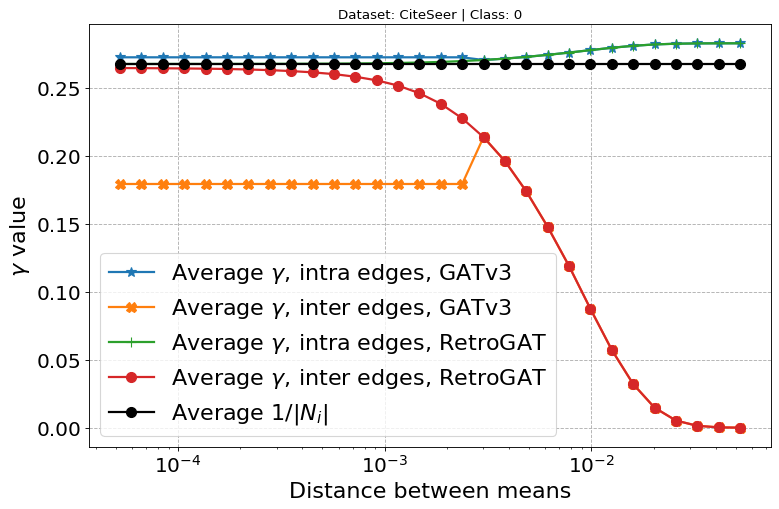

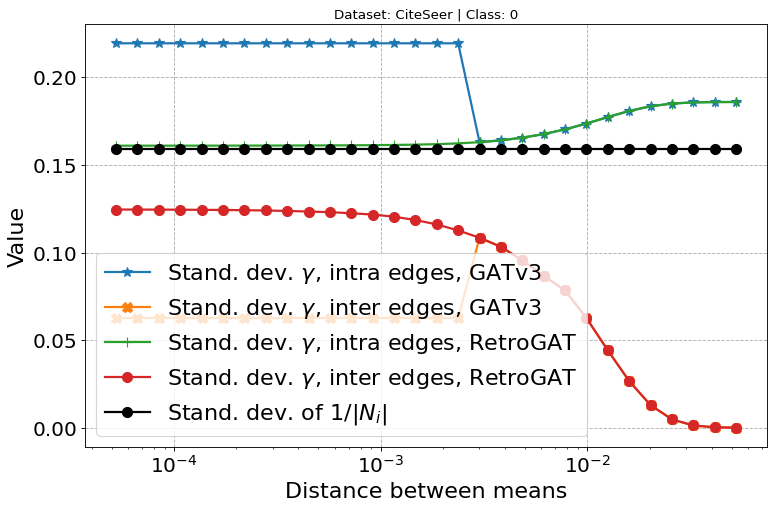

<Figure size 1280x960 with 0 Axes>

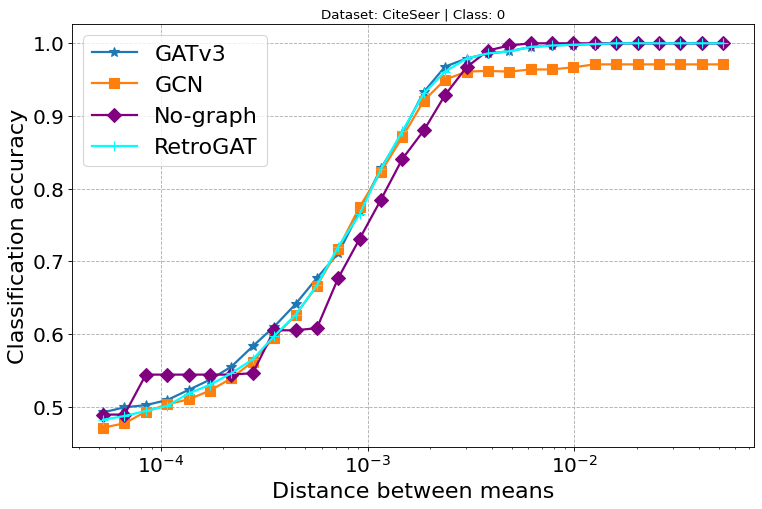

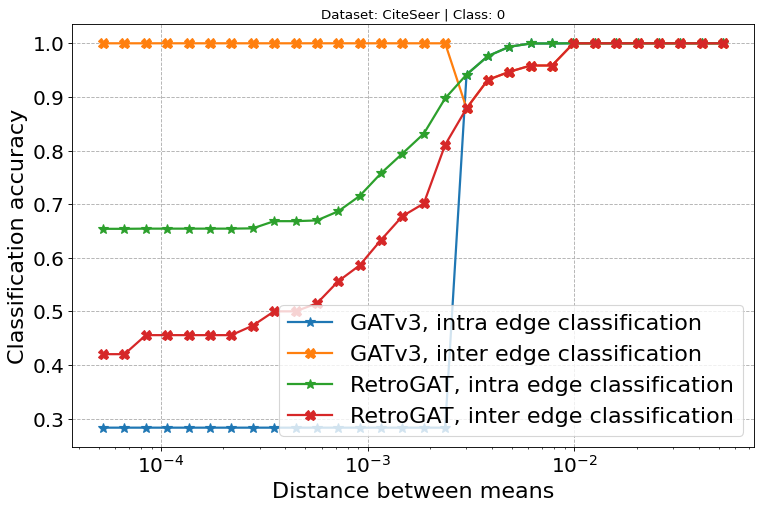

In [16]:
# datasets = [Planetoid(root='data/CiteSeer/', name='CiteSeer'), Planetoid(root='data/Cora/', name='Cora'), Planetoid(root='data/PubMed/', name='PubMed')]
datasets = [Planetoid(root='data/CiteSeer/', name='CiteSeer')]

for dataset in datasets:
    print(dataset.name)
    data = dataset[0].to(device)
    n_classes = data.y.max() + 1
    print("Number of classes: ", n_classes)
    
    n = data.y.shape[0]
    data.x_backup = copy.deepcopy(data.x) 
    degree = tg.utils.degree(data.edge_index[1], n)
    
    print (data.edge_index.shape, data.x.shape)
    
    for which_class in range(n_classes):
        print("Class: ", which_class)
        y = torch.zeros(n, dtype=torch.float64).to(device)
        idx = data.y == which_class
        y[idx] = 1
        data.ynew = y
        
        mean0 = data.x_backup[idx].mean(dim=0)
        mean1 = data.x_backup[~idx].mean(dim=0)
        
        distance = torch.norm(mean0-mean1)
        mu = distance/(2*torch.sqrt(torch.tensor(data.x.shape[1])))
        
        mu_up = 10*mu
        mu_lb = 0.01*mu
        print (distance, mu, mu_up, mu_lb)
        all_mus = np.geomspace(mu_lb.item(), mu_up.item(), 30, endpoint=True).tolist()
        print (all_mus)
        all_mus = np.asarray(all_mus)
        mus = torch.tensor(all_mus).to(device)
        
        test_acc_mlp_gat = []
        test_acc_retro = []
        test_acc_gcn = []
        test_acc_lin = []
        
        intra_gamma = []
        inter_gamma = []
        intra_gamma_std = []
        inter_gamma_std = []
        acc_intra_edges_all = []
        acc_inter_edges_all = []
        
        intra_gamma_retro = []
        inter_gamma_retro = []
        intra_gamma_std_retro = []
        inter_gamma_std_retro = []
        acc_intra_edges_all_retro = []
        acc_inter_edges_all_retro = []
        
        for mu_idx, mu_ in enumerate(mus):
            
            print (f"idx: {mu_idx}/{len(mus)} | current mu: {mu_}")
        
            new_mean0 = mu_*torch.ones(data.x.shape[1]).to(device)
            new_mean1 = -mu_*torch.ones(data.x.shape[1]).to(device)
            
            mu_tilda_diff = new_mean0 - new_mean1

            data.x[idx] = data.x_backup[idx] - mean0 + new_mean0
            data.x[~idx] = data.x_backup[~idx] - mean1 + new_mean1

            # GCN
            model_gcn_ansatz = create_ansatz_gcn(Model_GCN(data.x.shape[1], out_d=1).to(device), new_mean0, 1)
            train_acc, test_acc = measure_accuracy(model_gcn_ansatz, data)
            print(f"GCN\t\tTrain: {train_acc:0.4f} | Test: {test_acc:0.4f}")
            test_acc_gcn.append(test_acc)

            # Linear
            model_linear_ansatz = create_ansatz_linear(Model_linear(data.x.shape[1], out_d=1).to(device), new_mean0, 1)
            train_acc, test_acc = measure_accuracy(model_linear_ansatz, data)
            print(f"Linear\t\tTrain: {train_acc:0.4f} | Test: {test_acc:0.4f}")
            test_acc_lin.append(test_acc)
            
            # GATv3
            model_gatv3_ansatz = create_ansatz_mlp_gat(Model_GATv3(data.x.shape[1], out_d=1).to(device), new_mean0, 1)
            train_acc, test_acc, attn_weights, pair_pred = measure_accuracy_gat(model_gatv3_ansatz, data, mu_tilda_diff)
            print(f"MLP GAT ansatz\t\tTrain: {train_acc:0.4f} | Test: {test_acc:0.4f}")
            test_acc_mlp_gat.append(test_acc)
            
            intra_weight, idx_intra, inter_weight, idx_inter = info_mlp_gat(attn_weights, idx, 0)
            
            intra_gamma.append(np.asarray(intra_weight).mean())
            inter_gamma.append(np.asarray(inter_weight).mean())
            intra_gamma_std.append(np.asarray(intra_weight).std())
            inter_gamma_std.append(np.asarray(inter_weight).std())
            acc_intra_edges, acc_inter_edges = pair_acc(attn_weights[0][0].shape[0], pair_pred, idx_intra, idx_inter, 0)
            acc_intra_edges_all.append(acc_intra_edges.cpu())
            acc_inter_edges_all.append(acc_inter_edges.cpu())
            
            # RetroGAT 
            model_retro_ansatz = create_ansatz_mlp_gat(Model_OGGAT(data.x.shape[1], out_d=1).to(device), new_mean0, 1)
            train_acc, test_acc, attn_weights_retro, pair_pred_retro = measure_accuracy_gat_retro(model_retro_ansatz, data)
            print(f"RetroGAT ansatz\t\tTrain: {train_acc:0.4f} | Test: {test_acc:0.4f}")
            test_acc_retro.append(test_acc)

            intra_weight_retro, idx_intra_retro, inter_weight_retro, idx_inter_retro = info_mlp_gat(attn_weights_retro, idx, 0)

            intra_gamma_retro.append(np.asarray(intra_weight_retro).mean())
            inter_gamma_retro.append(np.asarray(inter_weight_retro).mean())
            intra_gamma_std_retro.append(np.asarray(intra_weight_retro).std())
            inter_gamma_std_retro.append(np.asarray(inter_weight_retro).std())

            acc_intra_edges_retro, acc_inter_edges_retro = pair_acc(attn_weights_retro[0][0].shape[0], pair_pred_retro, idx_intra_retro, idx_inter_retro, 0)
            acc_intra_edges_all_retro.append(acc_intra_edges_retro.cpu())
            acc_inter_edges_all_retro.append(acc_inter_edges_retro.cpu())
            
            print ("")
            print ("")            
            
        my_plot(dataset.name, which_class, mus, degree, 
            intra_gamma, inter_gamma, intra_gamma_std, inter_gamma_std,
            test_acc_mlp_gat, test_acc_gcn, test_acc_lin, test_acc_retro,
            acc_intra_edges_all, acc_inter_edges_all,
            intra_gamma_retro, inter_gamma_retro, intra_gamma_std_retro, inter_gamma_std_retro, 
            acc_intra_edges_all_retro, acc_inter_edges_all_retro,
            parent_path="real_data_retro_comparison")
        
        break